In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import networkx as nx

# Dataset

classic credit scoring binary classification dataset. downloaded from https://www.kaggle.com/datasets/uciml/german-credit

In [2]:
df = pd.read_csv('german_credit_data.csv', index_col=0)[:100]

In [3]:
target = df['Risk'].astype('category').cat.codes
df_bool = df['Sex'].astype('category').cat.codes
df_bool.name = 'Sex'
df['Job'] = df['Job'].astype('category')
df_cat = pd.get_dummies(df[['Job', 'Saving accounts', 'Checking account', 'Purpose']])
df_num = df[['Age', 'Credit amount', 'Duration']]

In [4]:
df_bool = pd.concat([df_bool, df_cat], axis=1)

<AxesSubplot:>

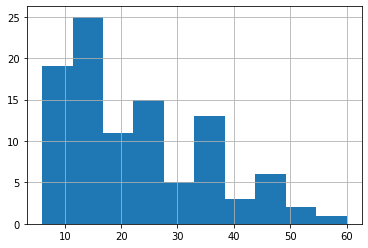

In [5]:
df_num['Duration'].hist()

<AxesSubplot:>

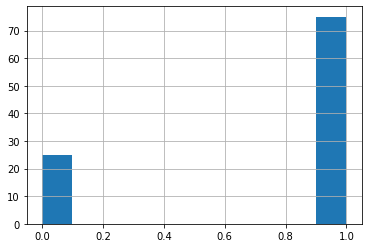

In [6]:
target.hist()

unbalanced labels -> use fscore (or whole coufusion matrix)

In [7]:
from utils import DataCollection
data = DataCollection(df_bool.values, df_num.values, target.values, batch_size=64)

# Binarization strategy

### Manual

In [8]:
# too boring, wont do that

### Statistical

In [9]:
from sklearn.preprocessing import KBinsDiscretizer

In [10]:
class SklearnBinarizer(nn.Module):
    def __init__(self, sklearn_discretizer):
        super().__init__()
        self.sklearn_discretizer = sklearn_discretizer
        
    def forward(self, x):
        x = self.sklearn_discretizer.transform(d_num)
        return torch.tensor(x.toarray(), dtype=torch.long)

In [11]:
discr = KBinsDiscretizer(strategy='quantile')
discr.fit(data.x_num['train'])
binarizer = SklearnBinarizer(discr)

### Neural

In [12]:
class NeuralBinarizer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.lin = nn.Linear(in_dim, out_dim)
    
    def forward(self, x):
        x = self.lin(x)
        return (torch.sigmoid(x)>0.5).to(torch.long)

In [13]:
binarizer = NeuralBinarizer(3, 15)

# Model

let's refactor the model into normal pytorch module, to be more flexible

In [14]:
from copy import copy
from dataclasses import dataclass
from typing import *
import networkx as nx

from fcapy.lattice import ConceptLattice
from fcapy.lattice.formal_concept import FormalConcept
from fcapy.poset import POSet
from fcapy.visualizer.line_layouts import calc_levels

import torch
import torch.nn as nn
from sparselinear import SparseLinear
    
class ConceptNetwork(nn.Module):
    def __init__(self, lattice, nonlinearity=nn.ReLU):
        super().__init__()
        attributes = tuple(lattice[lattice.bottom].intent)
        self._poset = self._poset_from_best_concepts(lattice, (False, True), attributes)
        
        spec = self._get_layer_specifications()
        self._spec = spec
        
        layers = self._get_layers_from_connections(spec, nonlinearity)
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)
    
    @dataclass
    class _POSetElement:
        intent: FrozenSet[str]
        _children: FrozenSet[int] = None

        def __eq__(self, other):
            return (self.intent == other.intent)

        def __le__(self, other):
            return (self.intent & other.intent == other.intent)

        def __hash__(self):
            return hash(self.intent)

    def _poset_from_best_concepts(
            self, best_concepts: List[FormalConcept], targets: Tuple[str], attrs_tpl: Tuple[str]) -> POSet:
        poset = POSet(best_concepts)

        best_neurons = set([self._POSetElement(frozenset(c.intent)) for c in poset])
        first_level_neurons = set([self._POSetElement(frozenset({m})) for m in attrs_tpl])
        last_level_neurons = set([self._POSetElement(frozenset({f"y={y}"} | set(attrs_tpl))) for y in targets])

        poset = POSet(first_level_neurons | best_neurons)# | last_level_neurons)
        for element in range(len(poset)):
            poset[element]._children = poset.children(element)
        return poset
    
    def _get_bipartite_connections(self, current_level, next_level):
        current_level = copy(current_level)
        next_level = copy(next_level)
        connections = []
        for i, element in enumerate(next_level):
            for j in self._poset.parents(element):
                connections.append((current_level.index(j),i))
                self._poset[j]._children = self._poset[j]._children.difference(set(next_level))

        for j, element in enumerate(current_level):
            if self._poset[element]._children:
                next_level.append(element)
                connections.append((j, len(next_level)-1))
        
        return len(current_level), len(next_level), connections, next_level
    
    def _get_layer_specifications(self):
        levels, level_table = calc_levels(self._poset)
        currnet_level = level_table[0]
        spec = []
        for i in range(1, len(level_table)):
            in_features, out_features, connections, currnet_level = self._get_bipartite_connections(currnet_level, level_table[i])
            spec.append((in_features, out_features, connections))
        return spec
    
    def networkx_graph(self):
        spec = self._spec
        pos = {}
        edges = {}
        total_nodes = 0
        all_connections = []
        for n, (in_features, out_features, connections) in enumerate(spec):
            connections_ = [(a+total_nodes, b+total_nodes+in_features) for (a,b) in connections]
            pos |= {i+total_nodes: [(i+1)/(in_features+1), -n] for i in range(in_features)}
            pos |= {i+total_nodes+in_features: [(i+1)/(out_features+1), -n-1] for i in range(out_features)}
            total_nodes += in_features
            all_connections.extend(connections_)
            
            weights = get_weights(self.network[n*2])
            edges |= dict(zip(connections_, weights))
            
        return nx.Graph(all_connections), pos, {frozenset(k):v.item() for k,v in edges.items()}
    
    def _get_layers_from_connections(self, spec, nonlinearity):
        linear_layers = []
        for in_features, out_features, connections in spec:
            connections = [(b,a) for (a,b) in connections]
            connectivity = torch.tensor(connections, dtype=torch.long).T
            layer = SparseLinear(in_features, out_features, connectivity=connectivity)
            # layer.weight.requires_grad = True
            linear_layers.append(layer)

        # layers = [layer for ll in linear_layers for layer in [ll, nonlinearity()]][:-1] + [nn.Sigmoid()]
        layers = [layer for ll in linear_layers for layer in [ll, nonlinearity()]][:-2] + [nn.Linear(in_features, 1), nn.Sigmoid()]
        return layers
    
    def edge_weigths(self):
        out = {}
        for layer, spec in zip(self.network, self._spec):
            if hasattr(layer, 'weight'):
                w = get_weights(layer)
            idx = spec[2]
            out |= dict(zip(idx, w))
        return {k:v.item() for k,v in out.items()}
    
def get_weights(x):
    if isinstance(x, SparseLinear):
        w = x.weight.values()
    else:
        w = x.weight.data[0]
    return w

In [15]:
import fcapy as fcapy
from fcapy.context import FormalContext
from fcapy.lattice import ConceptLattice
from fcapy.visualizer import LineVizNx

K_train = FormalContext(data.x_bool['train'].astype(bool), target=data.y['train'].astype(bool))

In [16]:
L_train = ConceptLattice.from_context(K_train, algo='Sofia', L_max=10, is_monotone=True)
L_train

starting construction
lattice constructed


0it [00:00, ?it/s]

In [17]:
cn = ConceptNetwork(L_train, nonlinearity=nn.ReLU)

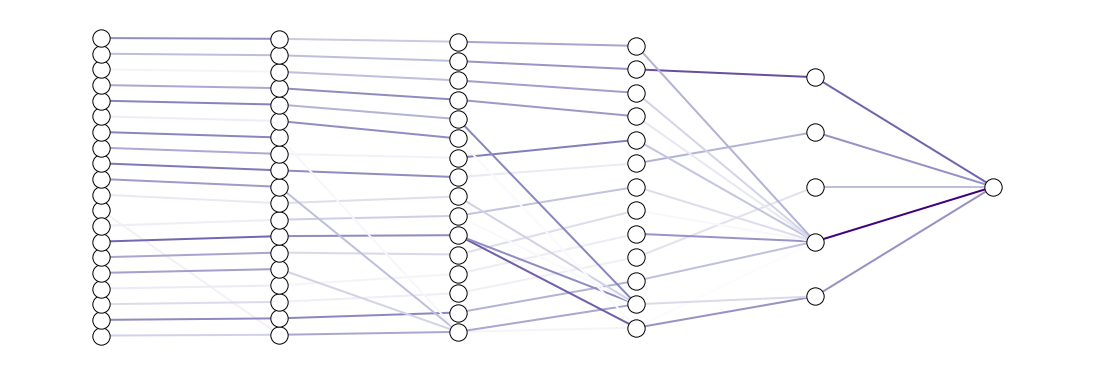

In [18]:
plt.figure(figsize=(15,5))
g, pos, weights = cn.networkx_graph()
pos_ = {node: (-y, x) for node, (x,y) in pos.items()}
nx.draw(
    g, pos_, edge_color=[weights[frozenset((u,v))] for u,v in g.edges], 
    edge_cmap=plt.cm.Purples, node_color='w', edgecolors='black', width=2)

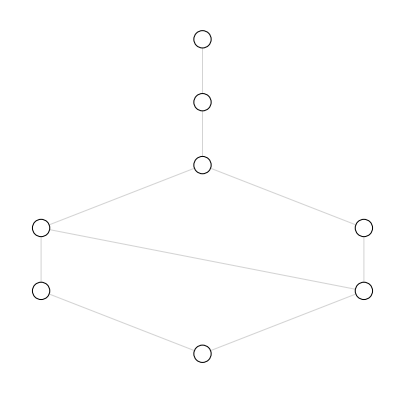

In [20]:
fig, ax = plt.subplots(figsize=(7,7))
vis = LineVizNx(node_border_color='g', node_color='w')
vis.draw_poset(L_train, ax=ax);

## Training

In [216]:
from tqdm.notebook import tqdm
X = data.train_ds.tensors[0].to(torch.float)
y = data.train_ds.tensors[2].to(torch.float)[:,None]
optimizer = torch.optim.Adam(cn.parameters(), lr=1e-3)
loss_fn = nn.BCELoss()

losses = []
for t in tqdm(range(2000)):
    optimizer.zero_grad()
    y_pred = cn(X)
    loss = loss_fn(y_pred, y)
    loss.backward()
    losses.append(loss.item())
    optimizer.step()

  0%|          | 0/2000 [00:00<?, ?it/s]

0.5623350739479065


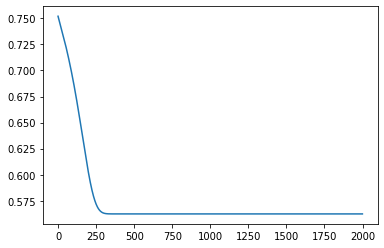

In [217]:
plt.plot(losses)
print(losses[-1])

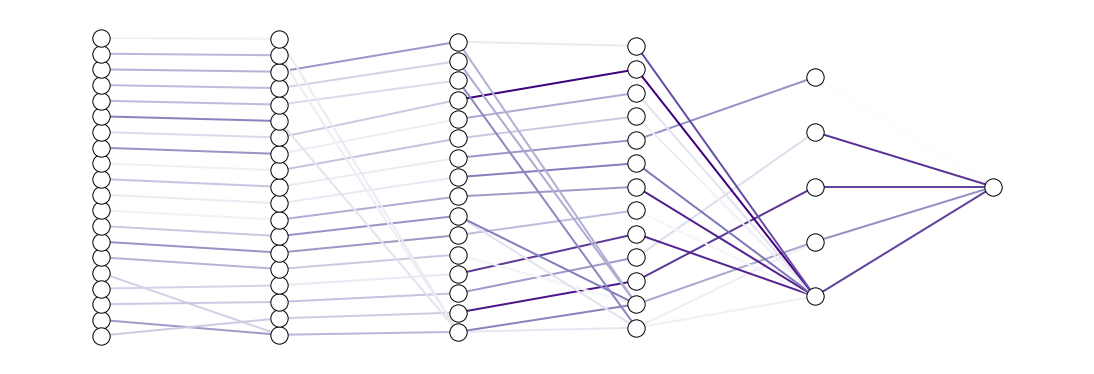

In [218]:
plt.figure(figsize=(15,5))
g, pos, weights = cn.networkx_graph()
pos_ = {node: (-y, x) for node, (x,y) in pos.items()}
nx.draw(
    g, pos_, edge_color=[weights[frozenset((u,v))] for u,v in g.edges], 
    edge_cmap=plt.cm.Purples, node_color='w', edgecolors='black', width=2)

# Experiments

# Other model comparison

knn, random forests, boosting, mlp, tabnet

couldnt make abything to work with a reasonable amount of effort, due to this field being so underdeveloped